In [ ]:
# default_exp msgmm

In [1]:
# export
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
from tqdm.notebook import tqdm, trange

In [2]:
nP = 1000
nU = 5000
m1 = np.zeros(2) + 1.5
m0 = np.zeros(2) - 1.5
s1 = np.eye(2)
s0 = np.eye(2)
f1 = ss.multivariate_normal(mean=m1,cov=s1)
f0 = ss.multivariate_normal(mean=m0,cov=s0)
xPos = f1.rvs(size=nP)
alpha = .5
xUnlabeled = np.concatenate([f1.rvs(size=int(alpha * nU)),
                             f0.rvs(size=int((1-alpha) * nU))],axis=0)

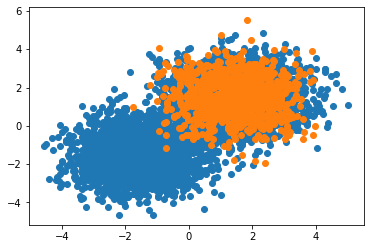

In [3]:
plt.scatter(*xUnlabeled.T)
plt.scatter(*xPos.T)

In [10]:
# export
class MSGMM:
    def __init__(self):
        pass
    def updateAlpha(self):
        self.alpha = np.mean(self.wiU)

    def updateBeta(self):
        self.beta = np.mean(self.wiL)

    def updateU1(self, xUnlabeled, xPos):
        self.u1 = (self.wiU.T @ xUnlabeled +self.wiL.T@xPos) / (np.sum(self.wiU) + np.sum(self.wiL))

    def updateU0(self, xUnlabeled, xPos):
        self.u0 = (((1-self.wiU).T@xUnlabeled) + ((1-self.wiL).T@xPos)) / (np.sum(1-self.wiU) + np.sum(1-self.wiL))

    def updateSigma1(self, xUnlabeled, xPos):
        s11 = xUnlabeled - np.repeat(self.u1[None], xUnlabeled.shape[0],0)
        s1 = s11.T @ np.diag(self.wiU.ravel()) @ s11
        s22 = xPos - np.repeat(self.u1[None],xPos.shape[0],0)
        s2 = s22.T @ np.diag(self.wiL.ravel()) @ s22
        self.sigma1 = (s1 + s2) / (np.sum(self.wiU) + np.sum(self.wiL))
    def updateSigma0(self, xUnlabeled, xPos):
        s11= xUnlabeled - np.repeat(self.u0[None],xUnlabeled.shape[0],0)
        s22 = xPos - np.repeat(self.u0[None], xPos.shape[0],0)
        s1 = s11.T @ np.diag(1 - self.wiU.ravel()) @ s11
        s2 = s22.T @ np.diag(1 - self.wiL.ravel()) @ s22
        self.sigma0 = (s1 + s2) / (np.sum(1 - self.wiU) + np.sum(1-self.wiL))

    def fit(self, xUnlabeled, xPos,verbose=True,iterations=100):
        self.wiL = np.random.beta(5,2,size=(xPos.shape[0]))
        self.wiU = np.random.beta(2,5,size=(xUnlabeled.shape[0]))
        for iteration in trange(iterations):
            # M-Step
            self.updateAlpha()
            self.updateBeta()
            self.updateU1(xUnlabeled,xPos)
            self.updateU0(xUnlabeled, xPos)
            self.updateSigma1(xUnlabeled,xPos)
            self.updateSigma0(xUnlabeled,xPos)
            # E-Step
            # Update unlabeled responsibilities
            phi1U= ss.multivariate_normal.pdf(xUnlabeled,mean=self.u1.ravel(),cov=self.sigma1)
            phi0U= ss.multivariate_normal.pdf(xUnlabeled,mean=self.u0.ravel(),cov=self.sigma0)
            self.wiU = self.alpha * phi1U / (self.alpha * phi1U + (1-self.alpha) * phi0U)
            # Update positive responsibilities
            phi1L= ss.multivariate_normal.pdf(xPos,mean=self.u1.ravel(),cov=self.sigma1)
            phi0L= ss.multivariate_normal.pdf(xPos,mean=self.u0.ravel(),cov=self.sigma0)
            self.wiL = self.beta * phi1L / (self.beta * phi1L + (1-self.beta) * phi0L)
            if verbose and not iteration % 5:
                print(np.concatenate((self.sigma1,self.sigma0),axis=1))
                print()
                print(self.alpha, self.beta, self.u1, self.u0)
                print()
                
    def predict_proba(self,x):
        phi1 = ss.multivariate_normal.pdf(x, mean=self.u1.ravel(),cov=self.sigma1)
        phi0 = ss.multivariate_normal.pdf(x,mean=self.u0.ravel(), cov=self.sigma0)
        return self.alpha * phi1 / (self.alpha * phi1 + (1 - self.alpha) * phi0)

In [5]:
msgmm = MSGMM()

In [7]:
msgmm.fit(xUnlabeled, xPos,iterations=500,verbose=False)

In [8]:
def truePosterior(x):
    return alpha * f1.pdf(x) / (alpha * f1.pdf(x) + (1-alpha) * f0.pdf(x))

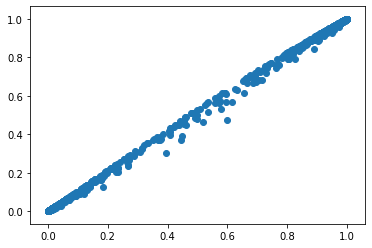

In [9]:
plt.scatter(msgmm.predict_proba(xUnlabeled),truePosterior(xUnlabeled))